<a href="https://colab.research.google.com/github/LoSgu8/Wi-Fi-encrypted-traffic-classification/blob/main/encrypted_traffic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wi-Fi encrypted traffic classification
## Wireless Network Project 2021/2022
## Sguotti Giacomo 10667547

### Import Block

In [ ]:
import pandas as pd
from os import listdir
from IPython.display import SVG


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import shap

### Project Workflow

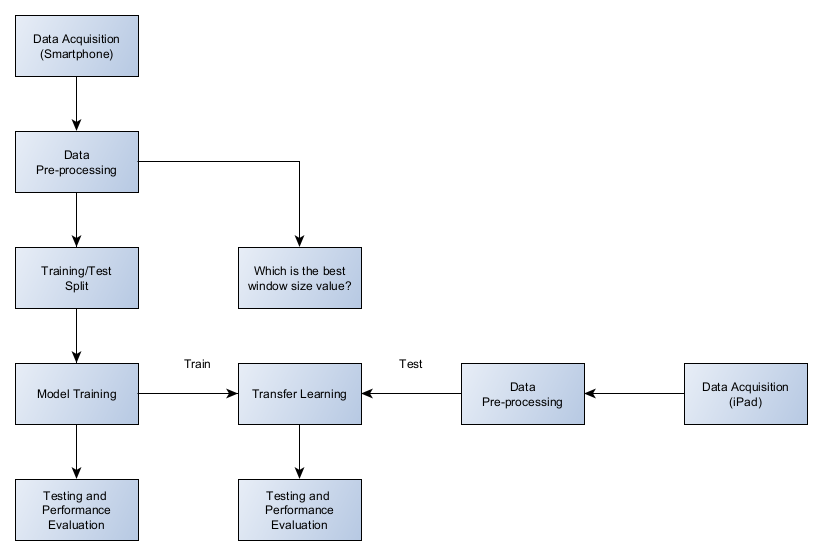

In [ ]:
from IPython.display import Image
Image(filename="workflow.png")

### Data Acquisition

Data Acquisition has been done using Wireshark in monitor mode. The data was acquired on different days and on two different STAs, a Google Pixel 4 smartphone and iPad 6th, respectively on ./captures and ./ipad_captures folder.

I have used the following Capture Filter ether host <device_mac>

Each .pcap file has a duration of roughly 1000 seconds and is named according to the activity it captures and the capture date.

Lastly, I exported them in csv format to be pandas friendly.

Below, for each device sniffed is initialized a list of their MAC addresses used during the capture

In [ ]:
smartphone_mac = ['0e:0e:13:54:d9:2f', '56:8f:0d:01:e1:84']
ipad_mac = ['ba:89:0e:f1:78:eb']

### Feature Extraction

The extracted features from the dataset are the following:
 - number of DL/UL Packets
 - Average Packet Size DL/UL
 - Packet Size Variance DL/UL
 - Average Inter-Arrival Time
 - Inter-Arrival Time Variance
 
 In case of missing packets in a window, I decided not to drop that information otherwise I lost the dead intervals which might be useful to identify idle or browsing classes.
 Instead a decided to instead to set averages to 0 and high value of variance (e.g 10) to indicate the uncertainty of the value.

In [ ]:
# Given the window size and the dataframe provided by get_dataset(), returns a dataframe with its features
def extract_stats(df, W):    
    start_time = 0
    end_time = start_time + W
    
    stat_df = pd.DataFrame(columns = ['# DL Packets', '# UL Packets', 'Avg Packet Size UL', 'Avg Packet Size DL', 'Packet Size Variance UL', 'Packet Size Variance DL', 'Average Inter-Arrival Time', 'Inter-Arrival Time Variance'])
    while df['Time'].iloc[-1] > end_time:
        #print ('Window from {} to {} seconds'.format(start_time, end_time))
        windowed_df = df[df['Time'].between(start_time, end_time)]
        
        uplink_df = windowed_df[windowed_df['Uplink'] == True]
        dwnlink_df = windowed_df[windowed_df['Uplink'] == False]
        
        nb_ul_pkts = uplink_df.shape[0]
        nb_dl_pkts = dwnlink_df.shape[0]
        
        if nb_ul_pkts > 0:            
            avg_size_ul = uplink_df['Length'].mean()
            var_size_ul = uplink_df['Length'].var()
        else:
            avg_size_ul = 0
            var_size_ul = 10
            
        if nb_dl_pkts > 0:    
            avg_size_dl = dwnlink_df['Length'].mean()
            var_size_dl = dwnlink_df['Length'].var()
        else:
            avg_size_dl = 0
            var_size_dl = 10
            
        if windowed_df.shape[0] > 0:
            avg_inter_arrival_time = windowed_df['Next Packet Arrival Time'].mean()
            var_inter_arrival_time = windowed_df['Next Packet Arrival Time'].var()
        else:
            avg_inter_arrival_time = 0
            var_inter_arrival_time = 10
            
        # Append a row with stats of the current window to stat_df
        new_row = [nb_dl_pkts, nb_ul_pkts, avg_size_ul, avg_size_dl, var_size_ul, var_size_dl, avg_inter_arrival_time, var_inter_arrival_time]
        stat_df.loc[len(stat_df)] = new_row
        # Update start and end time for the next window
        start_time = end_time
        end_time = start_time + W
    
    return stat_df

In [ ]:
# given the windows size W (in seconds) and the .csv captures directory,
# Input:
#   - W: window size in seconds
#   - directory: name of the direcory where to find all the .csv captures to analyze (relative path)
#   - device_mac: list of the MAC addresses of the sniffed device
#   - verbose: if True prints all the details of the aptured files (False by default)
# Output:
#   - df: the dataframe with all the features and the groundtruth(the activity) obtained from the .csv file
def get_dataset(W, directory, device_mac, verbose=False):
    df = pd.DataFrame()

    for capture_file in listdir(directory+'/'):
        if capture_file.endswith('.csv'):
            if verbose:
                print('Reading '+capture_file+'...')

            file_df = pd.read_csv(directory+'/'+capture_file, usecols=['Time', 'Source', 'Length'])
            
            if verbose:
                print('\tCapture Time: {} seconds'.format(file_df['Time'].iloc[-1]))
                print('\tNb. of packets: {}'.format(file_df.shape[0]))
                
            # Get direction from Source
            file_df['Uplink'] = (file_df['Source'].isin(device_mac))

            # Remove not used columns
            file_df = file_df.drop(['Source'], axis=1)
            
            # Add Inter-Arrival Time column and remove eventually introduced NaN values
            file_df['Next Packet Arrival Time'] = file_df['Time'].diff() 
            file_df.dropna(inplace=True)
            
            # Extract statistics
            file_stat = extract_stats(file_df, W)

            # Extract the activity from the file name
            activity = capture_file.split('_')[0]
            file_stat['Activity'] = activity

            # add it to the df dataframe
            df = pd.concat([file_stat, df])

    # Drop rows with NaN values
    df = df.dropna()
    
    return df

In [ ]:
window_size = 25
df = get_dataset(window_size, 'captures', smartphone_mac, verbose=True)

Reading browsing_22_05_07_2120.csv...
	Capture Time: 432.967093742 seconds
	Nb. of packets: 46952
Reading browsing_22_05_08_2300.csv...
	Capture Time: 744.163947674 seconds
	Nb. of packets: 27228
Reading idle_22_05_08_2020.csv...
	Capture Time: 1002.198040097 seconds
	Nb. of packets: 9380
Reading idle_22_05_22_1900.csv...
	Capture Time: 379.494813086 seconds
	Nb. of packets: 6720
Reading youtube_22_05_07_2115.csv...
	Capture Time: 401.133497107 seconds
	Nb. of packets: 38116
Reading youtube_22_05_08_2000.csv...
	Capture Time: 1008.937491459 seconds
	Nb. of packets: 984931


In [ ]:
# a preview of what the df looks like
df.head()

,# DL Packets,# UL Packets,Avg Packet Size UL,Avg Packet Size DL,Packet Size Variance UL,Packet Size Variance DL,Average Inter-Arrival Time,Inter-Arrival Time Variance,Activity
0,20565.0,4865.0,199.931757,1364.772623,39918.205046,44433.316611,0.000983,0.000084,youtube
1,35442.0,7742.0,177.471325,1399.175978,10933.524239,5560.307368,0.000575,0.000296,youtube
2,17212.0,3662.0,178.244675,1390.707936,16844.783057,14967.025088,0.001195,0.001647,youtube
3,25854.0,4842.0,176.218505,1399.640249,6746.163359,5030.243181,0.000818,0.000506,youtube
4,12657.0,3178.0,162.644116,1392.281188,7775.612998,13563.061019,0.001583,0.000828,youtube


### Scale, Split and Model Construction

In [ ]:
# Split the dataset in X and Y
y = df['Activity']
X_raw = df.drop(columns=['Activity'])

# Scale the features
scaler = StandardScaler().fit(X_raw)
X = scaler.transform(X_raw)

# Training/test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, shuffle=True)

# Check dimensions
print('Training set shape (features): {}'.format(X_train.shape))
print('Training set shape (labels): {}'.format(y_train.shape))
print('Test set shape (features): {}'.format(X_test.shape))
print('Test set shape (labels): {}'.format(y_test.shape))

Training set shape (features): (105, 8)
Training set shape (labels): (105,)
Test set shape (features): (52, 8)
Test set shape (labels): (52,)


### Model Training

In [ ]:
# Random Forest Classifier as model
rfc_clf = RandomForestClassifier(n_estimators = 200)

start = time.time()
rfc_clf.fit(X_train, y_train)
duration = time.time() - start

rfc_pred = rfc_clf.predict(X_test)

print('Training duration (s): {}'.format(duration))


Training duration (s): 0.13685274124145508


### Performance Evaluation

#### Confusion Matrix

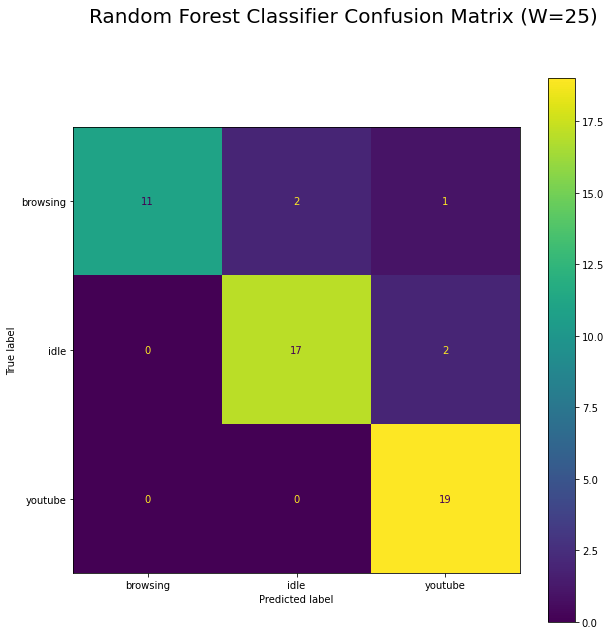

In [ ]:
cm = confusion_matrix(y_test, rfc_pred, labels=rfc_clf.classes_)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc_clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('Random Forest Classifier Confusion Matrix (W={})'.format(window_size), fontsize=20)

cmp.plot(ax=ax)

fig.savefig('results/confusion_matrix.png')

#### Metrics

In [ ]:
accuracy = accuracy_score(y_test, rfc_pred)

global_precision_score = precision_score(y_test, rfc_pred, average='weighted')
per_class_precision_score = precision_score(y_test, rfc_pred, average=None)

global_recall_score = recall_score(y_test, rfc_pred, average='weighted')
per_class_recall_score = recall_score(y_test, rfc_pred, average=None)

global_f1_score = f1_score(y_test, rfc_pred, average='weighted')
per_class_f1_score = f1_score(y_test, rfc_pred, average=None)

print('Accuracy: {}'.format(accuracy))

print('Precision global: {}'.format(global_precision_score))
print('Precision per class: {}'.format(per_class_precision_score))

print('Recall global: {}'.format(global_recall_score))
print('Recall per class: {}'.format(per_class_recall_score))

print('F1 Score global: {}'.format(global_f1_score))
print('F1 Score per class: {}'.format(per_class_f1_score))

Accuracy: 0.9038461538461539
Precision global: 0.9117132867132867
Precision per class: [1.         0.89473684 0.86363636]
Recall global: 0.9038461538461539
Recall per class: [0.78571429 0.89473684 1.        ]
F1 Score global: 0.9024953095684803
F1 Score per class: [0.88       0.89473684 0.92682927]


The model performed very well with an accuracy generally above the 85%.
I think that the level of uncertainty is due to the browsing class that is higly dependant from the user behaviour (think time and which web pages are visited)

### Which is the best window size?

The best value of W (according to accuracy) is 38 with an accuracy of 0.930952380952381.


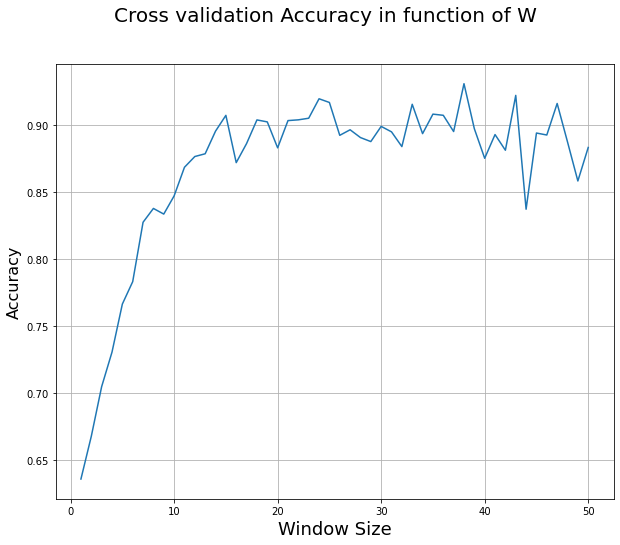

In [ ]:
# Let's find the window size that outputs the best cross validation accuracy on the entire set X (not only X_train)
accuracy = []

# values of window size to test
window_size_to_test = range(1, 51)

device_mac = ['0e:0e:13:54:d9:2f', '56:8f:0d:01:e1:84']

for window_size in window_size_to_test:
    print('Computing accuracy for W={}...'.format(window_size), end='\r')
    df = get_dataset(window_size, 'captures', device_mac)
    # Split the scaled dataset in X and Y
    y = df['Activity']
    X_raw = df.drop(columns=['Activity'])
    # Scaling
    scaler = StandardScaler()
    scaler.fit(X_raw)
    X = scaler.transform(X_raw)
    
    kf = KFold(n_splits=5, shuffle=True)
    accuracy.append(cross_val_score(rfc_clf, X, y, cv=kf, scoring='accuracy', n_jobs=-1).mean())

fig = plt.figure(figsize=(10, 8))
_plot = plt.plot(window_size_to_test, accuracy)
fig.suptitle('Cross validation Accuracy in function of W', fontsize=20)
plt.xlabel('Window Size', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
fig.savefig('results/w_vs_accuracy.png')
max_accuracy = max(accuracy)
best_W = window_size_to_test[accuracy.index(max_accuracy)]

print('The best value of W (according to accuracy) is {} with an accuracy of {}.'.format(best_W, max_accuracy))

The best window size higly depends from how the kFolds are shuffled, very likely by rerunning the block above you will get another best window size which may be different from the actual one.

Despite this randomicity, as expected the better performances can be obtained with window size higher than 15/20 seconds.
This is because the higher is the windows size the more accurate are the features obtained. For example, analyzing a browsing sample using a 1 second window size, you can get a download of the entire webpage of many MBs but at the same time you can obtain the sample at which the users is reading the webpage previously downloaded charachterized by a nearly to zero traffic.

Another thing to notice is that by increasing the window size, the set to study is reduced.

### Transfer Learning: Can the same model be applied also to a different device? (iPad)

I asked myself whether the model entirely trained on the my smartphone behaviour was accurated also on another device, an iPad.

In [ ]:
window_size = 25

smartphone_mac = ['0e:0e:13:54:d9:2f', '56:8f:0d:01:e1:84']
train_df = get_dataset(window_size, 'captures', smartphone_mac)

y_train = train_df['Activity']
X_train_raw = train_df.drop(columns=['Activity'])
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)

# Train a Random Forest Classifier with X_train and y_train
rfc_clf = RandomForestClassifier(n_estimators = 200)
rfc_clf.fit(X_train,y_train)

# Get iPad dataframe
ipad_mac = ['ba:89:0e:f1:78:eb']
ipad_df = get_dataset(window_size, 'ipad_captures', ipad_mac)

y_ipad = ipad_df['Activity']
X_raw = ipad_df.drop(columns=['Activity'])
scaler = StandardScaler()
scaler.fit(X_raw)
X_ipad = scaler.transform(X_raw)

ipad_pred = rfc_clf.predict(X_ipad)

#### Performance

In [ ]:
print('Testing the iPad set on the smartphone trained model resulted in an accuracy of {}.'.format(rfc_clf.score(X_ipad, y_ipad)))

Testing the iPad set on the smartphone trained model resulted in an accuracy of 0.5258620689655172.


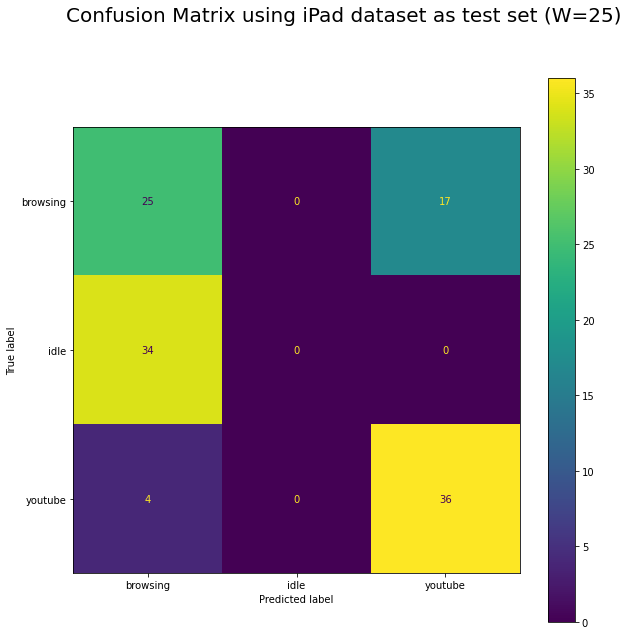

In [ ]:
cm = confusion_matrix(y_ipad, ipad_pred, labels=rfc_clf.classes_)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc_clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('Confusion Matrix using iPad dataset as test set (W={})'.format(window_size), fontsize=20)

cmp.plot(ax=ax)

fig.savefig('results/ipad_confusion_matrix.png')

The performances of the model deteriorated significantly.

In my opinion this is due to:
 - I noticed that iPad is much less active than my smartphone in idle period, it sends almost exclusively Probe Request every roughly 30 seconds. This is why the model tends to classify idle as browsing.
 - The browsing session on iPad might have been more traffic heavy with respect to the smartphone one.